In [8]:
!pip install tensorflow transformers
!pip install datasets
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.2 MB/s eta 0:00:00


In [9]:
from transformers import AlbertTokenizer, TFAlbertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import datasets
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Flatten, MaxPooling1D, Dropout
from keras.initializers import Constant
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import numpy as np
from imblearn.over_sampling import SMOTE

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Albert


## Pre Processing


In [2]:
def download_data():
    dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech')
    print(dataset)
    df = dataset['train'].to_pandas()
    df.describe()
    return df

def preprocess(binary = True):
    df = download_data()
    # keep the columns we need
    df = df[['text', 'hate_speech_score', 'annotator_severity']]

    # remove rows with NaN
    df = df.dropna()

    print(df.shape)

    # subtract the annotator severity from the hate speech score
    # df['hate_speech_score'] = df['hate_speech_score'] + df['annotator_severity']

    # remove rows with a negative hate speech score
    # df = df[df['hate_speech_score'] >= -1]

    print(df.shape)

    # split the data into offensive and hate speech, add new binary column
    # leave small buffer between offensive and hate speech to help with classification
    if binary:
      df_offensive = df[df['hate_speech_score'] < 0.5]
      df_offensive.loc[:, 'label'] = 0
      df_hate = df[df['hate_speech_score'] > 0.5]
      df_hate.loc[:, 'label'] = 1

    # combine the two dataframes
      df = pd.concat([df_offensive, df_hate])
    else:
      #Split for multi class labels : supportive, offensive, hate speech
      df_support = df[df['hate_speech_score'] < -1]
      df_offensive = df[(df['hate_speech_score'] < 0.5) & (df['hate_speech_score'] >= -1)]
      df_hate = df[df['hate_speech_score'] >= 0.5]

      df_support.loc[:, 'label'] = 0
      df_offensive.loc[:, 'label'] = 1
      df_hate.loc[:, 'label'] = 2

      df = pd.concat([df_support, df_offensive, df_hate])


    print(df['label'].value_counts())

    # graph the distribution of the hate speech score
    plt.hist(df['hate_speech_score'], bins=20)
    plt.title('Distribution of Hate Speech Score over 0')
    plt.savefig('hate_speech_score.png')

    return df


In [3]:
SPLIT_TRAIN = 0.7
SPLIT_VALIDATION = 0.5
BATCH_SIZE = 256
def split(dataset, y):
  train_data, temp_data, train_labels, temp_labels = train_test_split(dataset, y, test_size=1-SPLIT_TRAIN)
  val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=1-SPLIT_VALIDATION)

  return train_data, train_labels, val_data, val_labels, test_data, test_labels

def tokenize_and_batch(x_train,y_train, x_val, y_val,x_test, y_test, tokenizer):
  embedding_train = tokenizer(x_train, max_length=MAX_LEN, truncation=True, padding=True)
  embedding_val = tokenizer(x_val, max_length=MAX_LEN, truncation=True, padding=True)
  embedding_test = tokenizer(x_test, max_length=MAX_LEN, truncation=True, padding=True)

  dataset_train = tf.data.Dataset.from_tensor_slices((dict(embedding_train),y_train))
  dataset_val = tf.data.Dataset.from_tensor_slices((dict(embedding_val),y_val))
  dataset_test = tf.data.Dataset.from_tensor_slices((dict(embedding_test),y_test))

  return dataset_train.batch(BATCH_SIZE), dataset_val.batch(BATCH_SIZE), dataset_test.batch(BATCH_SIZE)



In [ ]:
MODEL = 'albert-base-v2'
MAX_LEN = 30
tokenizer = AlbertTokenizer.from_pretrained(MODEL)

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

## Binary classification

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

<ipython-input-3-ac876b83c104>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offensive.loc[:, 'label'] = 0
<ipython-input-3-ac876b83c104>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hate.loc[:, 'label'] = 1


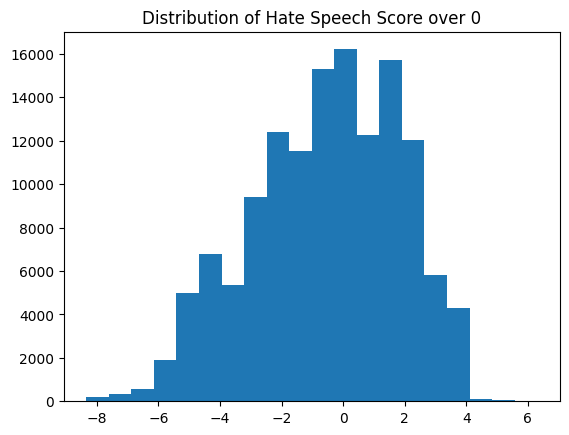

In [ ]:
df = preprocess()
x = df['text'].tolist()
y = df['label'].tolist()

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split(x, y)
train, validation, test = tokenize_and_batch(train_data, train_labels, val_data, val_labels, test_data, test_labels, tokenizer)

In [ ]:
EPOCHS = 10

model = TFAlbertForSequenceClassification.from_pretrained(MODEL, num_labels = 1)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.BinaryCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = validation)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
371/371 [==============================] - 566s 1s/step - loss: 0.2833 - auc: 0.8625 - precision: 0.9154 - recall: 0.6959 - val_loss: 0.2758 - val_auc: 0.8455 - val_precision: 0.9808 - val_recall: 0.6371
Epoch 2/10
371/371 [==============================] - 540s 1s/step - loss: 0.1819 - auc: 0.9229 - precision: 0.9419 - recall: 0.8326 - val_loss: 0.2279 - val_auc: 0.8714 - val_precision: 0.9779 - val_recall: 0.6958
Epoch 3/10
371/371 [==============================] - 540s 1s/step - loss: 0.1139 - auc: 0.9572 - precision: 0.9623 - recall: 0.9105 - val_loss: 0.1603 - val_auc: 0.9333 - val_precision: 0.9518 - val_recall: 0.8555
Epoch 4/10
371/371 [==============================] - 542s 1s/step - loss: 0.0854 - auc: 0.9687 - precision: 0.9720 - recall: 0.9344 - val_loss: 0.1489 - val_auc: 0.9526 - val_precision: 0.9364 - val_recall: 0.9224
Epoch 5/10
371/371 [==============================] - 541s 1s/step - loss: 0.0458 - auc: 0.9848 - precision: 0.9844 - recall: 0.9688 - val_l

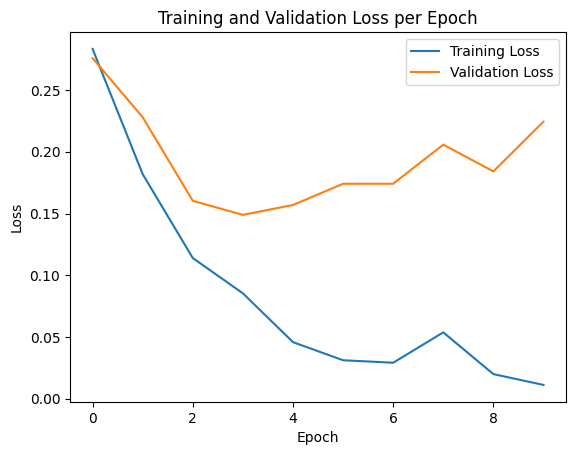

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def performance_binary(test, y_test, model, model_type='albert'):
    y_pred = model.predict(test)

    if model_type == 'albert':
        y_pred_classes = (y_pred.logits > 0.5).astype("int32")
    else:
        y_pred_classes = (y_pred > 0.5).astype("int32")

    cm = confusion_matrix(y_test, y_pred_classes)
    print("Confusion Matrix:\n", cm)

    cr = classification_report(y_test, y_pred_classes)
    print("\nClassification Report:\n", cr)

    if model_type == 'albert':
        fpr, tpr, thresholds = roc_curve(y_test, y_pred.logits)
        auc = roc_auc_score(y_test, y_pred.logits)
    else:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



80/80 [==============================] - 40s 504ms/step
Confusion Matrix:
 [[12860    40]
 [  343  7057]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     12900
           1       0.99      0.95      0.97      7400

    accuracy                           0.98     20300
   macro avg       0.98      0.98      0.98     20300
weighted avg       0.98      0.98      0.98     20300



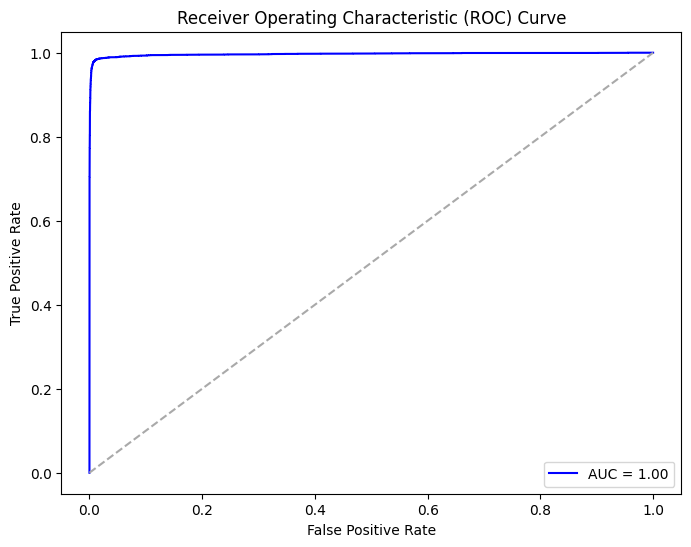

In [ ]:
performance_binary(test, test_labels, model)

In [ ]:
model.save_pretrained('./model/binary_HS')

## Multi-class classification

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

<ipython-input-3-ac876b83c104>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_support.loc[:, 'label'] = 0
<ipython-input-3-ac876b83c104>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offensive.loc[:, 'label'] = 1
<ipython-input-3-ac876b83c104>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

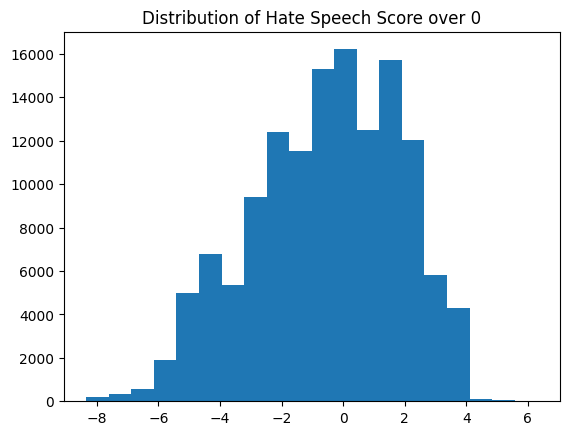

In [ ]:
df = preprocess(False)
x = df['text'].tolist()
y = df['label'].tolist()
y = to_categorical(y, num_classes = 3)

In [ ]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split(x, y)
train, validation, test = tokenize_and_batch(train_data, train_labels, val_data, val_labels, test_data, test_labels,  tokenizer)

In [ ]:
EPOCHS = 10

model = TFAlbertForSequenceClassification.from_pretrained(MODEL, num_labels = 3)
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = validation)

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
371/371 [==============================] - 561s 1s/step - loss: 0.5486 - auc_1: 0.8646 - precision_1: 0.6100 - recall_1: 0.8999 - val_loss: 0.4564 - val_auc_1: 0.8860 - val_precision_1: 0.6338 - val_recall_1: 0.9416
Epoch 2/10
371/371 [==============================] - 542s 1s/step - loss: 0.3982 - auc_1: 0.9047 - precision_1: 0.6783 - recall_1: 0.9440 - val_loss: 0.3934 - val_auc_1: 0.9056 - val_precision_1: 0.6871 - val_recall_1: 0.9427
Epoch 3/10
371/371 [==============================] - 535s 1s/step - loss: 1.0004 - auc_1: 0.6140 - precision_1: 0.6599 - recall_1: 0.1124 - val_loss: 1.0727 - val_auc_1: 0.6629 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
371/371 [==============================] - 534s 1s/step - loss: 0.6720 - auc_1: 0.8289 - precision_1: 0.7976 - recall_1: 0.5525 - val_loss: 0.5698 - val_auc_1: 0.8766 - val_precision_1: 0.7845 - val_recall_1: 0.6933
Epoch 5/10
371/371 [==============================] - 534s 1s/step - loss: 0.5281 - 

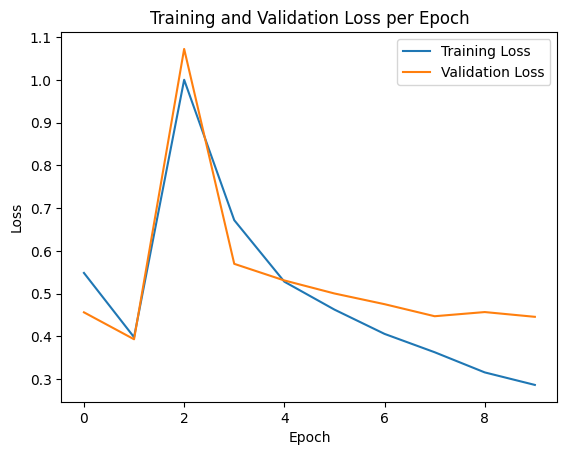

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
def performance_multi(x_test, y_test, model, model_type='albert'):

  y_pred = model.predict(x_test)
  if model_type == 'albert':
    y_pred_classes = np.argmax(y_pred.logits, axis=1)
  else:
    y_pred_classes = np.argmax(y_pred, axis=1)

  y_test_classes = np.argmax(y_test, axis=1)

  accuracy = accuracy_score(y_test_classes, y_pred_classes)
  report = classification_report(y_test_classes, y_pred_classes, target_names=['support', 'offensive', 'hate'])
  conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

  print("Accuracy:", accuracy)
  print("\nClassification Report:\n", report)
  print("\nConfusion Matrix:\n", conf_matrix)

In [ ]:
performance_multi(test, test_labels, model)

80/80 [==============================] - 39s 490ms/step
Accuracy: 0.8587587292219927

Classification Report:
               precision    recall  f1-score   support

     support       0.93      0.88      0.90      8106
   offensive       0.75      0.76      0.75      4963
        hate       0.87      0.91      0.89      7265

    accuracy                           0.86     20334
   macro avg       0.85      0.85      0.85     20334
weighted avg       0.86      0.86      0.86     20334


Confusion Matrix:
 [[7102  759  245]
 [ 407 3785  771]
 [ 157  533 6575]]


In [ ]:
model.save_pretrained('./model/multi_HS')

Code inspired by Hugging Face tutorial : https://colab.research.google.com/github/peterbayerle/huggingface_notebook/blob/main/distilbert_tf.ipynb

# CNN


## Pre Process

In [6]:
def load_glove_embeddings(glove_file, word_index, embedding_dim):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vectors

    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

<ipython-input-2-ac876b83c104>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offensive.loc[:, 'label'] = 0
<ipython-input-2-ac876b83c104>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hate.loc[:, 'label'] = 1


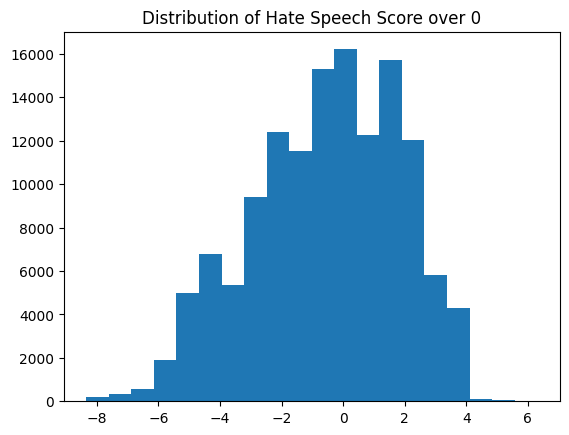

In [10]:
df = preprocess()
x = df['text']
y = df['label']

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
EPOCHS = 10
BATCH_SIZE = 256
embedding_dim = 100
max_length = 50
trunc_type = 'post'
padding_type = 'post'

In [13]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [18]:
embedding_matrix = load_glove_embeddings('glove.twitter.27B.100d.txt', word_index, embedding_dim)
vocab_size = len(word_index) + 1

'''
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(24, activation='relu'),
    Dense(12, activation='relu'),
    Dense(1, activation='sigmoid')
])
'''
loss = losses.BinaryCrossentropy(from_logits=True)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=loss, optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(padded_val, y_val))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


371/371 [==============================] - 86s 229ms/step - loss: 0.6110 - accuracy: 0.8181 - auc_1: 0.8901 - precision_1: 0.8133 - recall_1: 0.6486 - val_loss: 0.3276 - val_accuracy: 0.8681 - val_auc_1: 0.9408 - val_precision_1: 0.9109 - val_recall_1: 0.7034
Epoch 2/10
371/371 [==============================] - 90s 241ms/step - loss: 0.3256 - accuracy: 0.8692 - auc_1: 0.9376 - precision_1: 0.8622 - recall_1: 0.7622 - val_loss: 0.3039 - val_accuracy: 0.8769 - val_auc_1: 0.9482 - val_precision_1: 0.9148 - val_recall_1: 0.7268
Epoch 3/10
371/371 [==============================] - 101s 271ms/step - loss: 0.3086 - accuracy: 0.8771 - auc_1: 0.9452 - precision_1: 0.8687 - recall_1: 0.7799 - val_loss: 0.2871 - val_accuracy: 0.8841 - val_auc_1: 0.9533 - val_precision_1: 0.8882 - val_recall_1: 0.7769
Epoch 4/10
371/371 [==============================] - 84s 225ms/step - loss: 0.2968 - accuracy: 0.8822 - auc_1: 0.9501 - precision_1: 0.8733 - recall_1: 0.7906 - val_loss: 0.2798 - val_accuracy: 0.

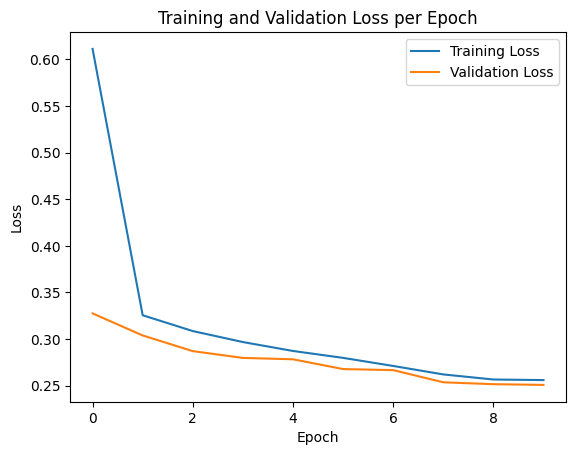

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

635/635 [==============================] - 9s 15ms/step
Confusion Matrix:
 [[12512   514]
 [ 1396  5878]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     13026
           1       0.92      0.81      0.86      7274

    accuracy                           0.91     20300
   macro avg       0.91      0.88      0.89     20300
weighted avg       0.91      0.91      0.90     20300



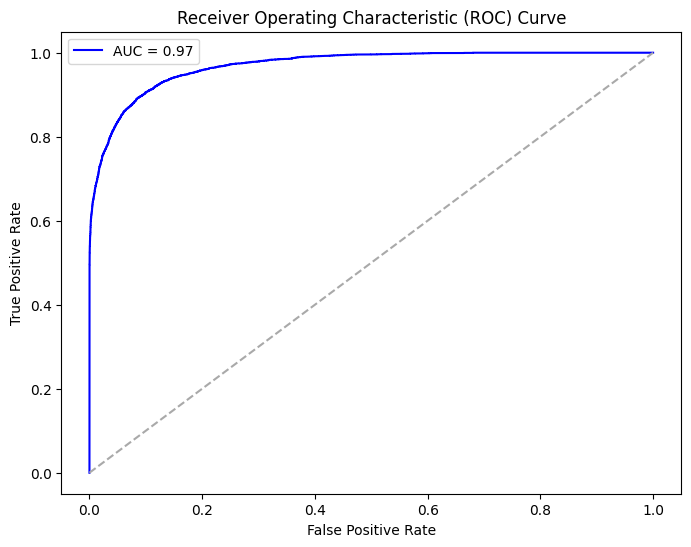

In [24]:

performance_binary(padded_test, y_test, model, 'cnn')

## Multi-class classification

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

<ipython-input-2-ac876b83c104>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_support.loc[:, 'label'] = 0
<ipython-input-2-ac876b83c104>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_offensive.loc[:, 'label'] = 1
<ipython-input-2-ac876b83c104>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

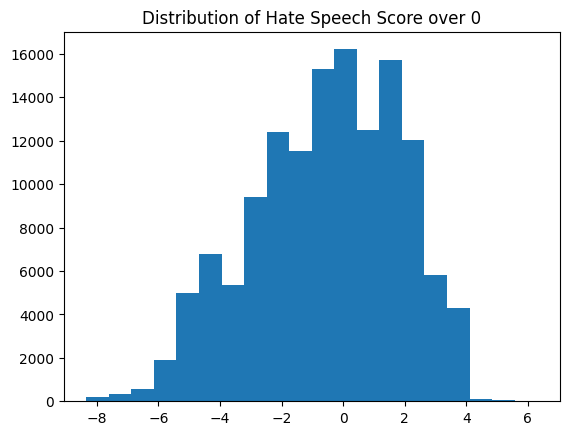

In [25]:
df = preprocess(False)
x = df['text']
y = df['label']
y = to_categorical(y, num_classes = 3)

In [26]:
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [27]:
EPOCHS = 10
BATCH_SIZE = 256
embedding_dim = 100
max_length = 50
trunc_type = 'post'
padding_type = 'post'

In [28]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequences_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_val = pad_sequences(sequences_val, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [30]:
embedding_matrix = load_glove_embeddings('glove.twitter.27B.100d.txt', word_index, embedding_dim)
vocab_size = len(word_index) + 1

loss = losses.BinaryCrossentropy(from_logits=True)


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, embeddings_initializer=Constant(embedding_matrix), trainable=False))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Train the model
history = model.fit(padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(padded_val, y_val))


Epoch 1/10
371/371 [==============================] - 125s 330ms/step - loss: 1.0596 - accuracy: 0.6667 - auc_2: 0.8533 - precision_2: 0.7892 - recall_2: 0.5206 - val_loss: 0.6167 - val_accuracy: 0.7447 - val_auc_2: 0.9142 - val_precision_2: 0.8439 - val_recall_2: 0.6381
Epoch 2/10
371/371 [==============================] - 83s 223ms/step - loss: 0.6208 - accuracy: 0.7409 - auc_2: 0.9108 - precision_2: 0.8359 - recall_2: 0.6334 - val_loss: 0.5879 - val_accuracy: 0.7546 - val_auc_2: 0.9211 - val_precision_2: 0.8934 - val_recall_2: 0.5961
Epoch 3/10
371/371 [==============================] - 84s 226ms/step - loss: 0.5925 - accuracy: 0.7502 - auc_2: 0.9182 - precision_2: 0.8446 - recall_2: 0.6424 - val_loss: 0.5650 - val_accuracy: 0.7628 - val_auc_2: 0.9258 - val_precision_2: 0.8744 - val_recall_2: 0.6299
Epoch 4/10
371/371 [==============================] - 84s 226ms/step - loss: 0.5761 - accuracy: 0.7573 - auc_2: 0.9231 - precision_2: 0.8480 - recall_2: 0.6544 - val_loss: 0.5619 - val_a

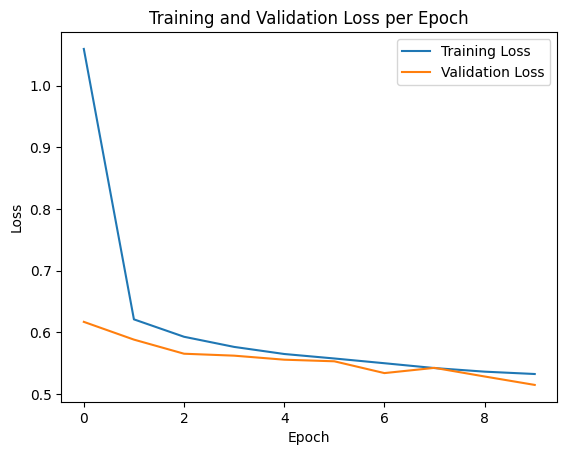

In [32]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
performance_multi(padded_test, y_test, model, 'cnn')

636/636 [==============================] - 6s 9ms/step
Accuracy: 0.7947772204190027

Classification Report:
               precision    recall  f1-score   support

     support       0.84      0.87      0.85      8048
   offensive       0.61      0.61      0.61      4895
        hate       0.87      0.83      0.85      7391

    accuracy                           0.79     20334
   macro avg       0.77      0.77      0.77     20334
weighted avg       0.80      0.79      0.80     20334


Confusion Matrix:
 [[6988  920  140]
 [1128 3002  765]
 [ 201 1019 6171]]
